In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# A model of the retina up until the retinal ganglion cells (RGCs)

In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
from copy import deepcopy
import pickle
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import h5py
from jax import jit, value_and_grad, vmap
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

from jax.scipy.signal import convolve2d
import jaxley as jx
from jaxley.channels import HH
#from jaxley.synapses import GlutamateSynapse

2025-01-20 11:29:07.752712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737368947.765159   18331 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737368947.768887   18331 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Define setup

In [4]:
# Set these to change what cell you want
date = "2020-07-08"
stimulus = "noise_1500"
exp_num = "1"
cell_id = date + "_" + exp_num

# Get the home directory
home_directory = os.path.expanduser("~")

# Set the path to the data directory where results will be stored
base_dir = f'{home_directory}/GitRepos/jaxley_rgc/deistler_our_data_and_morph'
assert os.path.exists(base_dir), f'{base_dir} does not exist.'

In [5]:
all_dfs = pd.read_pickle(f"{base_dir}/results/data/setup.pkl")
cell_id = "2020-07-08_1"
cell = jx.read_swc(f"{base_dir}/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0)

is_off_bc = True  # for OFF-BCs, we compute `(1-image)` as the light stimulus, leading to an inverted bc activity.

# General hyperparameters.
num_pixels = (20, 15)
pixel_size = 30


# OPL hyperparameters.
gaussian_kernel_std = 20.0
kernel_size = 50


# BC hyperparameters.
size_multiplier_for_bc_grid_x = 0.9  # How much larger should the BC grid be, compared to one image.
size_multiplier_for_bc_grid_y = 0.8  # How much larger should the BC grid be, compared to one image.
bc_spacing = 40.0

# Define offsets for the center of the grid for BCs -- this does not influence results as long
# as the BC grid covers the cell.
offset_for_bc_center_x = 30.0
offset_for_bc_center_y = 10.0

soma_x = cell.xyzr[1][0, 0] - offset_for_bc_center_x
soma_y = cell.xyzr[1][0, 1] - offset_for_bc_center_y
bc_grid_start_x = soma_x - 7.5 * pixel_size * size_multiplier_for_bc_grid_x
bc_grid_start_y = soma_y - 10.0 * pixel_size * size_multiplier_for_bc_grid_y

bc_grid_size_x = 450.0 * size_multiplier_for_bc_grid_x  # um
bc_grid_size_y = 600.0 * size_multiplier_for_bc_grid_y  # um

/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/utils/misc_utils.py:97: UserWarning: nseg is deprecated and will be removed in version 0.6.0.
  warnings.warn(msg + self._amend_msg)


# Outer plexiform layer: a linear filter

In [96]:
def center_surround_filter(spatial_axis, std1=50, std2=200):
    amp1 = 1 / std1
    gaussian1 = amp1 * np.exp(-spatial_axis**2 / std1**2)
    
    amp2 = 1 / std2
    gaussian2 = amp2 * np.exp(-spatial_axis**2 / std2**2)
    
    spatial_kernel = gaussian1 - gaussian2
    return spatial_kernel


def gaussian_filter(spatial_axis, std=50):
    amp1 = 1 / std
    gaussian1 = amp1 * np.exp(-spatial_axis**2 / std**2)
    return gaussian1


# spatial_axis = np.linspace(-600, 600, 1000)
# center_surround_kernel = center_surround_filter(spatial_axis)
# gaussian_kernel = gaussian_filter(spatial_axis)

# fig, ax = plt.subplots(1, 2, figsize=(6, 2))
# _ = ax[0].plot(spatial_axis, center_surround_kernel)
# _ = ax[1].plot(spatial_axis, gaussian_kernel)

In [97]:
def upsample_image(image, pixel_size, kernel_size):
    """Returns a new image where every value is one micro meter in size."""
    image = np.repeat(image, (pixel_size,), axis=0)
    image = np.repeat(image, (pixel_size,), axis=1)
    image_full = np.zeros((image.shape[0] + 2*kernel_size - 1, image.shape[1] + 2*kernel_size - 1))
    image_full[kernel_size:-kernel_size+1,kernel_size:-kernel_size+1] = image 
    return image_full

In [98]:
def build_opl_kernel(filter: str, std, filter_size):
    res_filter = 100
    center = [0., 0.]
    
    pos_x = np.linspace(-filter_size, filter_size, res_filter)
    pos_y = np.linspace(-filter_size, filter_size, res_filter)
    X, Y = np.meshgrid(pos_x, pos_y)
    
    dist_x = center[0] - X
    dist_y = center[1] - Y
    
    dists = np.sqrt(dist_x**2 + dist_y**2)

    if filter == "Gaussian":
        kernel = gaussian_filter(dists, std) / 100.0
    elif filter == "center_surround":
        raise NotImplementedError
        kernel = center_surround_filter(dists) / 100.0
    else:
        raise ValueError

    return kernel

def opl(image, kernel):
    """Performs linear spatial filtering with a provided kernel."""
    bc_input = convolve2d(image, kernel, mode="valid")
    return bc_input

# Bipolar cell: input output mapping

Values grabbed from Schwartz et al. 2012, Fig 7c.

In [99]:
class BipolarCell:
    """Given input current, return output of bipolar cells."""

    def __init__(self, max_input):
        self.x_vals = [-100, -50, -25, -12.5, -6.75, -3, 3, 6.75, 12.5, 25.0, 50.0, 100.0]
        self.response = [-0.05, -0.12, -0.15, -0.1, -0.08, -0.03, 0.1, 0.18, 0.37, 0.64, 0.85, 1.0]
        self.intensity = (1.0 + 1.0 / 100 * np.asarray(self.x_vals)) / 2.0

        # To scale the input-output curve, we have to know the maximal input current.
        self.max_input = max_input

    def __call__(self, input):
        standardized_bc_input = input / self.max_input
        bc_output = np.interp(standardized_bc_input, self.intensity, self.response)
        return bc_output

# Build Bipolar cell grid helpers

In [100]:
def get_bc_cell_locations(spacing, bc_grid_size_x, bc_grid_size_y):
    """Return x- and y-location of BCs at origin zero.
    
    Args:
        spacing: Distance between BCs (in um).
    """
    gap_x = spacing
    gap_y = np.sqrt(gap_x ** 2 - (gap_x/2) **2)
    x_locs = np.arange(0, bc_grid_size_x, gap_x)
    y_locs = np.arange(0, bc_grid_size_y, gap_y)
    
    all_x_locs, all_y_locs = np.meshgrid(x_locs, y_locs)
    all_x_locs[::2] += gap_x / 2
    
    all_x_locs = all_x_locs.flatten()
    all_y_locs = all_y_locs.flatten()

    return all_x_locs, all_y_locs


def move_bc_locations(x_loc_bipolar, y_loc_bipolar, x_move, y_move):
    """Move the locations of the bipolar cells to the image center."""
    # TODO: need to move it to the center of the cell, and the grid of BCs has to cover the whole space.
    bc_loc_x = x_loc_bipolar + x_move
    bc_loc_y = y_loc_bipolar + y_move
    return bc_loc_x, bc_loc_y


def get_image_locs(df):
    im_pos_x = np.linspace(-7.5*pixel_size + 0.5, 7.5*pixel_size - 0.5, 15*pixel_size) + df["image_center_x"].item()
    im_pos_y = -np.linspace(-10.0*pixel_size + 0.5, 10.0*pixel_size - 0.5, 20*pixel_size) + df["image_center_y"].item()
    return im_pos_x, im_pos_y


def discretize_bc_output(bc_output, bc_loc_x, bc_loc_y, im_pos_x, im_pos_y):
    """Given the (almost continuous) BC output grid, compute the position of BC cells."""
    pixel_size = 30  # um
    
    grid_x, grid_y = np.meshgrid(im_pos_x, im_pos_y)
    
    dists = []
    output_vals_at_bc_loc = []
    
    for x, y in zip(bc_loc_x, bc_loc_y):
        dist_x = (grid_x - x)**2
        dist_y = (grid_y - y)**2
        dist = np.sqrt(dist_x + dist_y)
        min_ind = np.unravel_index(np.argmin(dist), dist.shape)
        dists.append(min_ind)
        output_vals_at_bc_loc.append(bc_output[min_ind])
    
    dists = np.asarray(dists)
    
    # Standardize to [0, 1] range.
    output_vals_at_bc_loc = output_vals_at_bc_loc - np.min(output_vals_at_bc_loc)
    output_vals_at_bc_loc = output_vals_at_bc_loc / np.max(output_vals_at_bc_loc)

    return output_vals_at_bc_loc

# Run all scan fields

In [112]:
# rec_id = 1
rec_ids = ['d' + str(i) for i in range(1, 8)]
for rec_id in rec_ids:


    print(f"Rec id {rec_id}")
    roi_id = 1  # Does not matter.

    # Read image information.
    df = all_dfs[all_dfs["cell_id"] == cell_id]
    df = df[df["rec_id"] == rec_id]
    df = df[df["roi_id"] == roi_id]
    im_pos_x, im_pos_y = get_image_locs(df)

    # Read stimulus information.
    file = h5py.File(f"{base_dir}/data/noise.h5", 'r+')
    noise_stimulus = file["NoiseArray3D"][()]

    if is_off_bc:
        noise_stimulus = 1.0 - noise_stimulus

    # PR and BC instantiation.
    opl_kernel = build_opl_kernel(filter="Gaussian", std=gaussian_kernel_std, filter_size=kernel_size)
    max_of_bc_inputs = np.max(opl(np.ones((200, 200)), opl_kernel))
    BC = BipolarCell(max_of_bc_inputs)

    # Build grid of BCs.
    bc_loc_x_origin_0, bc_loc_y_origin_0 = get_bc_cell_locations(bc_spacing, bc_grid_size_x, bc_grid_size_y)
    bc_loc_x, bc_loc_y = move_bc_locations(bc_loc_x_origin_0, bc_loc_y_origin_0, bc_grid_start_x, bc_grid_start_y)


    activities_across_time = []
    for time_point in range(noise_stimulus.shape[2]):
        

        if time_point % 10 == 0:
            print(f"Time point {time_point}")
        
        image = noise_stimulus[:, :, time_point].T

        # OPL and IPL.
        upsampled_image = upsample_image(image, pixel_size, kernel_size)
        bc_input = opl(upsampled_image, opl_kernel)
        bc_output = BC(bc_input)

        # Assign BCs the corresponding activity.
        bipolar_cell_activity = discretize_bc_output(bc_output, bc_loc_x, bc_loc_y, im_pos_x, im_pos_y)
        activities_across_time.append(bipolar_cell_activity)

    activities_across_time = np.asarray(activities_across_time).T

    # debug
    print("Lengths:")
    print(f"bc_id: {len(np.arange(1, len(bc_loc_x)+1))}")
    print(f"x_loc: {len(bc_loc_x)}")
    print(f"y_loc: {len(bc_loc_y)}")
    print(f"activity: {len(activities_across_time)}")


    # Save as bipolar cell output.
    bipolar_cell = pd.DataFrame().from_dict({"cell_id": [cell_id] * len(bc_loc_x), 
                                             "rec_id": [rec_id] * len(bc_loc_x), 
                                             "bc_id": np.arange(1, len(bc_loc_x)+1), 
                                             "x_loc": bc_loc_x, 
                                             "y_loc": bc_loc_y, 
                                             "activity": activities_across_time.tolist()})
    
    bipolar_cell.to_pickle(f"{base_dir}/results/data/off_bc_output_rec_id_{cell_id}_{rec_id}.pkl")

Rec id d6
Time point 0
Time point 10
Time point 20
Time point 30
Time point 40
Time point 50
Time point 60
Time point 70
Time point 80
Time point 90
Time point 100
Time point 110
Time point 120
Time point 130
Time point 140
Time point 150
Time point 160
Time point 170
Time point 180
Time point 190
Time point 200
Time point 210
Time point 220
Time point 230
Time point 240
Time point 250
Time point 260
Time point 270
Time point 280
Time point 290
Time point 300
Time point 310
Time point 320
Time point 330
Time point 340
Time point 350
Time point 360
Time point 370
Time point 380
Time point 390
Time point 400
Time point 410
Time point 420
Time point 430
Time point 440
Time point 450
Time point 460
Time point 470
Time point 480
Time point 490
Time point 500
Time point 510
Time point 520
Time point 530
Time point 540
Time point 550
Time point 560
Time point 570
Time point 580
Time point 590
Time point 600
Time point 610
Time point 620
Time point 630
Time point 640
Time point 650
Time point 

### Merge all disk-written results

In [102]:
dfs = []
for rec_id in rec_ids:
    df = pd.read_pickle(f"{base_dir}/results/data/off_bc_output_rec_id_{cell_id}_{rec_id}.pkl")
    dfs.append(df)

dfs = pd.concat(dfs)
dfs.to_pickle(f"{base_dir}/results/data/off_bc_output_{cell_id}.pkl")

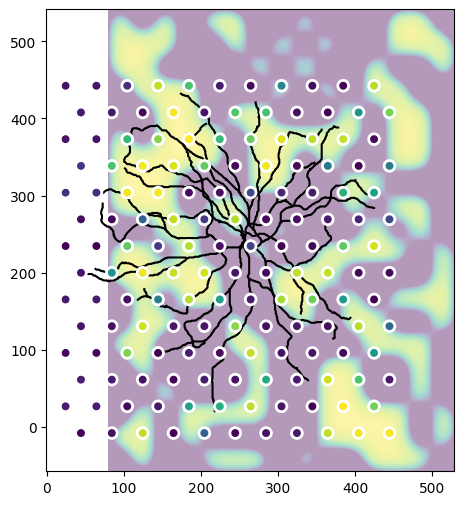

In [103]:
#with mpl.rc_context(fname="../../.matplotlibrc"):
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

_ = ax.imshow(bc_output, extent=[im_pos_x[0], im_pos_x[-1], im_pos_y[-1], im_pos_y[0]], clim=[0, 1], alpha=0.4, cmap="viridis")

for a, b, c in zip(bc_loc_x, bc_loc_y, bipolar_cell_activity):
    cmap = mpl.colormaps['viridis']
    _ = ax.scatter(a, b, s=40.0, color=cmap(c), zorder=10000)
    _ = ax.scatter(a, b, s=60.0, zorder=10000, facecolors='none', edgecolors='w', linewidth=2.0)

ax = cell.vis(ax=ax)#, morph_plot_kwargs={"alpha": 0.4})
# plt.savefig("results/figs/rgc_within_bc_grid.png", dpi=200, bbox_inches="tight")
plt.show()

# Visualizations

In [104]:
# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#     _ = ax[0].imshow(image, extent=[0, 450, 0, 600], cmap="gray")
#     _ = ax[0].imshow(opl_kernel, extent=[0, 100, 0, 100], cmap="Blues")
#     _ = ax[0].set_xlim([0, 450])
#     _ = ax[0].set_ylim([0, 600])
#     _ = ax[1].imshow(bc_input[25:-25, 25:-25], extent=[0, 450, 0, 600])
#     _ = ax[0].set_title("Light")
#     _ = ax[1].set_title("BC input")



# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(1, 0.75))
#     _ = ax.plot(BC.intensity, BC.response)
#     _ = ax.scatter(BC.intensity, BC.response)
#     _ = ax.set_xlabel("Intensity")
#     _ = ax.set_ylabel("Response")
#     # plt.savefig("results/figs/nonlinear_bc.png", dpi=200, bbox_inches="tight")



# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(11, 3))
#     _ = ax.imshow(opl_kernel, extent=[0, 100, 0, 100], cmap="Blues")
#     _ = ax.spines["bottom"].set_visible(False)
#     _ = ax.spines["left"].set_visible(False)
#     _ = ax.set_xticks([])
#     _ = ax.set_yticks([])
#     # plt.savefig("results/figs/gaussian_blog.png", dpi=200, bbox_inches="tight")



# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 3, figsize=(11, 3))
#     _ = ax[0].imshow(image, extent=[0, 450, 0, 600], cmap="Grays")
#     _ = ax[0].imshow(opl_kernel, extent=[0, 100, 0, 100], cmap="Blues")
#     _ = ax[1].imshow(bc_input, extent=[0, 450, 0, 600])
#     _ = ax[2].imshow(bc_output, extent=[0, 450, 0, 600])

#     for i in range(3):
#         _ = ax[i].set_xlim([0, 450])
#         _ = ax[i].set_ylim([0, 600])
#     _ = ax[0].set_title("Light")
#     _ = ax[1].set_title("BC input")
#     _ = ax[2].set_title("BC output")
#     for i in range(1, 3):
#         _ = ax[i].set_yticklabels([])
#     # plt.savefig("results/figs/overview.png", dpi=200, bbox_inches="tight")



# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
#     _ = ax.imshow(bc_output, extent=[im_pos_x[0], im_pos_x[-1], im_pos_y[-1], im_pos_y[0]], clim=[0, 1], alpha=0.4, cmap="viridis")
    
#     for a, b, c in zip(bc_loc_x, bc_loc_y, bipolar_cell_activity):
#         cmap = mpl.colormaps['viridis']
#         _ = ax.scatter(a, b, s=40.0, color=cmap(c), zorder=10000)
#         _ = ax.scatter(a, b, s=60.0, zorder=10000, facecolors='none', edgecolors='w', linewidth=2.0)
    
#     ax = cell.vis(ax=ax, morph_plot_kwargs={"alpha": 0.4})
#     # plt.savefig("results/figs/rgc_within_bc_grid.png", dpi=200, bbox_inches="tight")
# plt.show()

# Temporal kernel: probably not needed because the input is constant over time

In [105]:
temporal_axis = np.linspace(0, 100, 1000)

amp = 1.0  # positive for ON-bipolar-cells, negative for OFF-bipolar cells.
b0 = 1.0  # level of residual polarisation when light stimulation has stopped.
tau_rf = 10.0

temporal_kernel = (amp * temporal_axis**2 / 2 / tau_rf**3 * np.exp(-temporal_axis / tau_rf) + b0)

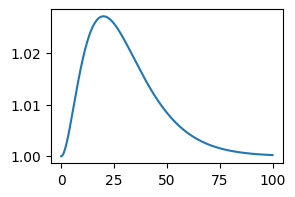

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.plot(temporal_axis, temporal_kernel)

# IPL 

In [107]:
bc_to_ac = np.zeros((5, 5))
bc_to_ac[[2, 2, 2], [1, 2, 3]] = 1.0
bc_to_ac[[1, 2, 3], [2, 2, 2]] = 1.0

ac_to_bc = np.zeros((5, 5))
ac_to_bc[[2, 2, 2, 2, 2], [0, 1, 2, 3, 4]] = 1.0
ac_to_bc[[0, 1, 2, 3, 4], [2, 2, 2, 2, 2]] = 1.0
ac_to_bc[[1, 3, 1, 3], [1, 1, 3, 3]] = 1.0

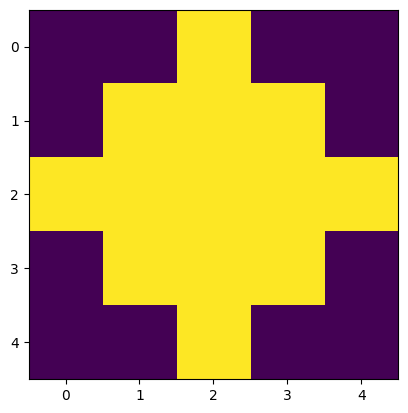

In [108]:
plt.imshow(ac_to_bc)

In [109]:
bc_res = 100
ac_res = 100

activity_bc = jnp.zeros((bc_res, bc_res))
activity_ac = jnp.zeros((ac_res, ac_res))

In [110]:
def vectorfield_bc(activity_bc, activity_ac):
    input_current_bc = convolved_signal  # Need to adjust dimensions
    input_current_bc -= activity_bc  # Decay term

    output_current_ac = convolve2d(activity_ac, ac_to_bc)
    input_current_bc -= output_current_ac
    return input_current_bc


def step_bc(activity_bc, activity_ac):
    rate_of_change = vectorfield_bc(activity_bc, activity_ac)
    activity_bc = activity_bc + dt * rate_of_change
    return activity_bc


def vectorfield_ac(activity_ac, activity_bc):
    input_current_ac = -activity_ac  # Decay term

    output_current_bc = convolve2d(activity_bc, bc_to_ac)
    input_current_ac -= output_current_bc
    return input_current_ac


def step_ac(activity_ac, activity_bc):
    rate_of_change = vectorfield_ac(activity_ac, activity_bc)
    activity_ac = activity_ac + dt * rate_of_change
    return activity_ac